In [23]:
# import for Data usage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField, MarkovTransitionField
from PIL import Image

# import for path usage
import glob
import os

In [24]:
file_paths = glob.glob('Data/*.csv')
files_names = [os.path.basename(file).split(".")[0] for file in file_paths]

In [25]:
dfs = [pd.read_csv(file,header=0) for file in file_paths]

In [26]:
list_of_dic_df_and_name = []
for i in range(len(dfs)):
    e = {}
    e['Name'] = files_names[i]
    e['Data'] = dfs[i]
    list_of_dic_df_and_name.append(e)

In [27]:
Xdf = list_of_dic_df_and_name[0]["Data"]
Xdf = Xdf.dropna()
# Xdf = Xdf [:1280]
Xdf = Xdf.drop(columns="nb_persons_SH")

In [31]:
def images_creation(df):
    # Ensure the Datetime column is sorted
    df = df.sort_values(by='Datetime')
    
    # Set parameters
    samples_per_day = 36  # 24 hours * 6 samples per hour (every 10 minutes)
    n_days = df.shape[0] // samples_per_day
    n_features = df.shape[1] - 1  # Subtracting the Datetime column
    
    # Drop the Datetime column for processing
    df = df.drop(columns=['Datetime'])

    # Reshape data to (n_days, samples_per_day, n_features)
    data_reshaped = df.values.reshape(n_days, samples_per_day, n_features)

    # Parameters for image transformation
    image_size = 32

    # Transformations
    gasf = GramianAngularField(image_size=image_size, method='summation')
    gadf = GramianAngularField(image_size=image_size, method='difference')
    mtf = MarkovTransitionField(image_size=image_size)

    # Function to transform and concatenate MTS data into an RGB image
    def transform_to_rgb(mts_data):
        n_samples, n_timestamps, n_features = mts_data.shape
        images = []
        
        for i in range(n_samples):
            sample_images = []
            for j in range(n_features):
                ts = mts_data[i, :, j]
                gasf_image = gasf.fit_transform(ts.reshape(1, -1))[0]
                gadf_image = gadf.fit_transform(ts.reshape(1, -1))[0]
                mtf_image = mtf.fit_transform(ts.reshape(1, -1))[0]

                # Stack GASF, GADF, and MTF images to form an RGB image
                rgb_image = np.stack([gasf_image, gadf_image, mtf_image], axis=-1)
                sample_images.append(rgb_image)
            
            # Concatenate feature images side by side
            concat_image = np.concatenate(sample_images, axis=1)
            images.append(concat_image)
        
        return np.array(images)

    # Transform the data
    images = transform_to_rgb(data_reshaped)
    return images

/home/damaggio/miniconda3/lib/python3.11/site-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/home/damaggio/miniconda3/lib/python3.11/site-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/home/damaggio/miniconda3/lib/python3.11/site-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/home/damaggio/miniconda3/lib/python3.11/site-packages/pyts/preprocess

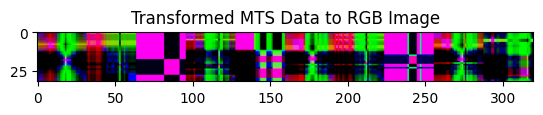

In [32]:
# Create images
images = images_creation(Xdf)

# Create a directory to save the images if it doesn't exist
output_dir = 'Results/set_of_36_samples'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save all the images
for i, img_array in enumerate(images):
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    img.save(os.path.join(output_dir, f'transformed_image_{i}.png'))

# Display the first image as an example
plt.imshow(images[0])
plt.title('Transformed MTS Data to RGB Image')
plt.show()